In [1]:
#hide
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
#MNIST is a collection of handwritten digits

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()
#This is a fastai custom function that returns a special list type called L

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [6]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [7]:
#Lets just take a look at our data before we work with it
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png'),Path('train/3/10093.png'),Path('train/3/10097.png'),Path('train/3/10099.png'),Path('train/3/10116.png'),Path('train/3/10125.png'),Path('train/3/10137.png'),Path('train/3/10141.png'),Path('train/3/10144.png'),Path('train/3/10155.png'),Path('train/3/10161.png')...]

In [8]:
#let's look at an image:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [9]:
#quick way to visualize the image info
#the numbers are slicing it from 4 inclusive to 10 exclusive


In [10]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [11]:
#same thing with tensors:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [12]:
#pd here is panda, we could do to learn more about it.
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


#but anyway that represents a digit fairly well.
#I know you have dark reader on but present that 0 is white.

The first way we're going to try to classify these is by pixel similarity:
We're going to average the pixels for each example of three and each of seven.
Then we're going to try to see which is most similar to our test.

In [13]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

As a side note, that way of created a list is called List Comprehension.
You could do somethhing like
new_list = [f(o) for o in a_list if o>0]
if you want to get conditional with it.

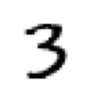

In [14]:
#Let's look at an image to make sure our data make sense.
show_image(three_tensors[1]);

In [15]:
#we're going to make these tensors 3d by stacking them.
# we're also going to cast them as float, which is needed for many things
# we're also dividing by 255 so that our values are in a 0-1 range.
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [16]:
#The length of a tensor's shape is its rank
len(stacked_threes.shape)

3

In [17]:
#we can also get it directly
stacked_threes.ndim

3

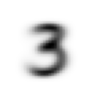

In [18]:
#now we're going to compute the mean, 0 indicates the axis to average on.
mean3 = stacked_threes.mean(0)
show_image(mean3);

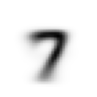

In [19]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

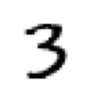

In [20]:
#here's an example 3 to test our similarity function with:
a_3 = stacked_threes[1]
show_image(a_3);

How can we now rank how far any examle is from our 'ideal' 3?
We can't just use total difference in darkness because some areas will make up for others when dark and light cancel out.
There's two ways data scientists usually do this:
1. Take the mean of the absolute values of the differences. This is called the mean absolute difference or L1 norm.
2. Take the mean of the square of differences (makes all positive, then take the square root (undoes squaring) This is called Root Mean Squared RMS or L2 norm.

In [21]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [22]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [23]:
#remember this is a loss function, so the 3 is closer to 3s than 7s, which is good.
# Pytorch has these in torch.nn.functional, which pytorch recommends importing as F
# fastai automatically has it imported as F
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

S: Intuitively, the difference between L1 norm and mean squared error (MSE) is that the latter will penalize bigger mistakes more heavily than the former (and be more lenient with small mistakes).

The book talks a bit about the differences between pytorch and numpy
functionally there are some things that numpy can't do on the gpu.
pytorch tensors always work on gpu.
numpy arrays can be jagged (ie not all of layer same shape) pytorch tensors cannot.

In [24]:
#create numpy array or a pytorch tensor by just calling array() or tensor()
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [25]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [26]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [27]:
#we're going to quickly go over some operations.
# in fast ai you can use the same ones on numpy arrays but we're just doing tensors
#select a row (0 indexed)
tns[1]

tensor([4, 5, 6])

In [28]:
#or a column
# ':' means all of the first axis
tns[:,1]

tensor([2, 5])

In [29]:
#You can combine these with Python slice syntax ([start:end] with end being excluded)
#to select part of a row or column:

tns[1,1:3]

tensor([5, 6])

In [30]:
#can do normal math:

tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [31]:
#tensors have a type:
tns.type()

'torch.LongTensor'

In [32]:
#it will change automatically as needed, for instance from int to float:

tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

We're going to need a validation set later, so lets make one now.
JK there's a folder called valid, they made one in the original dataset.
Let's create tensors from those to help us measure the quality of our algorithm.

In [33]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Check shapes frequently to ensure they make sense
here we have two tensors that are long containing 28 x 28 images, so this checks out.
We're going to define a simple function to be our error function

In [34]:

def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

If we now want to do this to the entire data set we can instead pass the entire validation 3 tensor

In [35]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1438, 0.1308, 0.1246,  ..., 0.1156, 0.1154, 0.1409]),
 torch.Size([1010]))

Broadcasting is basically where the function artificially makes the tensors the same size for the sake of whatever is happening. 

In [36]:

tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

In our code we have a rank 2 tensor for our mean 3 and it's broadcasted across all the validation 3s

In [37]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

PyTorch doesn't actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn't actually allocate any additional memory
<br>It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!)

In [38]:

def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [39]:

is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [40]:
#whole set:

is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [41]:
#calculate the accuracy by taking the average of that function for 3, and inverse for 7

accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [44]:
#man that's surprisingly good.
#let's be real though gradient descent is the goat


Book is now talking about gradient descent. Largely review from the video but I'll summarize lightly.
We need these things for gradient descent to work:
Initialization (random)
Loss Function
Step (a way to figure out direction of movement)
Stop (a reason to stop)

Our step is calculated using gradients

In [45]:


def f(x): return x**2

In [46]:
#requires grad tells pytorch we want to calculate gradients with respect to that variable at that value
xt = tensor(3.).requires_grad_()

In [47]:
yt = f(xt)
yt
    

tensor(9., grad_fn=<PowBackward0>)

In [48]:
yt.backward()

In [49]:

xt.grad

tensor(6.)

In [50]:
#same thing with vectors:

xt = tensor([3.,4.,10.]).requires_grad_()
xt
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [51]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

Goes over learning rates and the issues with too big/too large
too large will step past the solution
too small will take too long.

Will very quickly go through the example which is a rollercoaster going over a hump, gets slower towards the peak then speeds up on the way out.


In [52]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

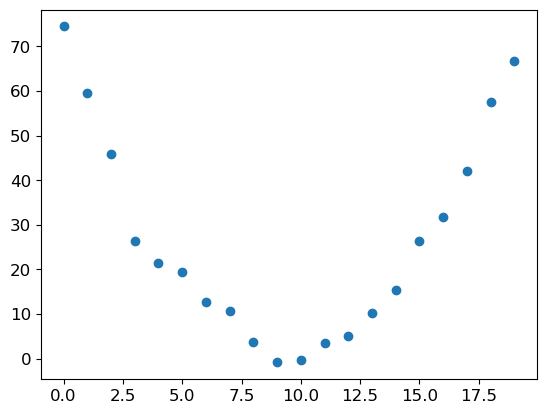

In [53]:

speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

Adding noise so learning is actually conflicted.

In [55]:
#separate params and t for ease of reading
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c
     

In [56]:
#define loss function:
def mse(preds, targets): return ((preds-targets)**2).mean()

In [57]:
#initialize params:
params = torch.randn(3).requires_grad_()
orig_params = params.clone() #not required

In [58]:
#make our first predictions:
preds = f(time, params)

In [59]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

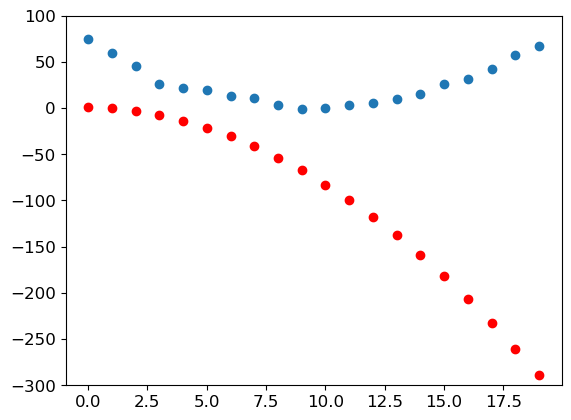

In [60]:

show_preds(preds)

In [61]:
#current loss:

In [62]:
loss = mse(preds, speed)
loss
     

tensor(25823.8086, grad_fn=<MeanBackward0>)

In [64]:
#get grads
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

In [65]:
#learning rate = .00001
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

In [66]:

params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

In [67]:
#update weights
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [68]:
#new loss:

preds = f(time,params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

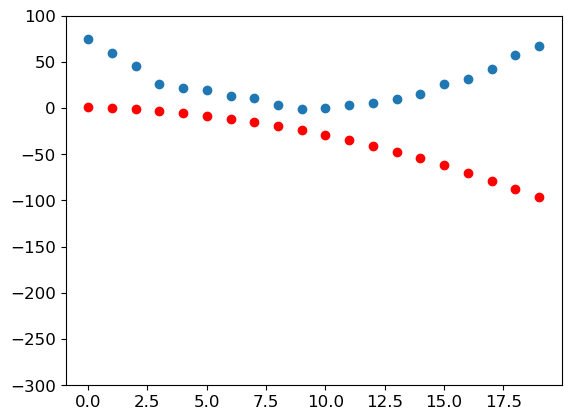

In [69]:
show_preds(preds)

In [71]:
#function to do all that at once


def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [72]:
#iterate
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


In [73]:
params = orig_params.detach().requires_grad_()

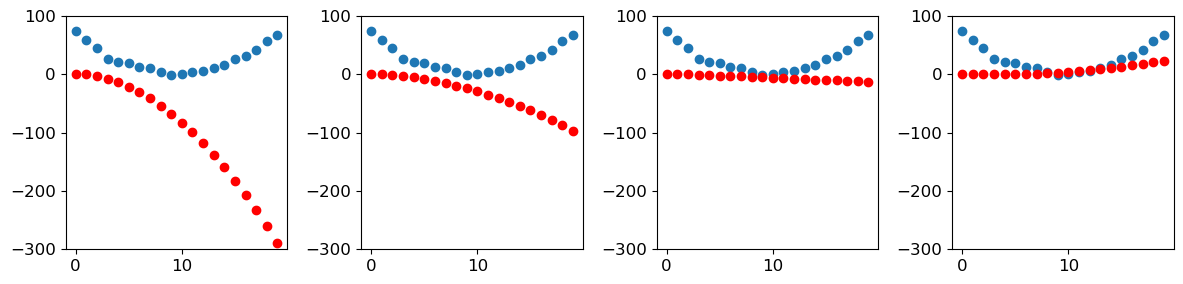

In [74]:

_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

So let's make a loss function for our digits dataset.
We can contatenate our inputs by using .view.
-1 is a special parameter that means "maake this axis as big as necessary.

In [75]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [76]:
#1 for 3, 0 for 7
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape
     

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In Pytorch a Dataset object needs tto return a tuple of (x,y) when indexed.
Python's zip function along with list can easily put them together:

In [77]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [79]:
#validation set same steps
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))
     

In [80]:
#random pixel weight initialization:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()


In [81]:
weights = init_params((28*28,1))

In [82]:
#don't forget the bias:
bias = init_params(1)

book explains that weights are like the m and biases are like the b.
Again this is review for you from Deep Learning.


In [83]:
(train_x[0]*weights.T).sum() + bias


tensor([20.2336], grad_fn=<AddBackward0>)

In [84]:
#Matrix multiplication is represented with @ now apparently
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

In [85]:
#check accuracy
corrects = (preds>0.0).float() == train_y
corrects
     

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [86]:
#.item converts from a tensor to a python number (our tensor is size 1 after the mean)
corrects.float().mean().item()

0.4912068545818329

They try to write their own loss function but it's weird, basically tries to take the difference between 0 or 1 and the confidence towards either case.
Anyway they want it bound between 0 and 1 so we're going sigmoid

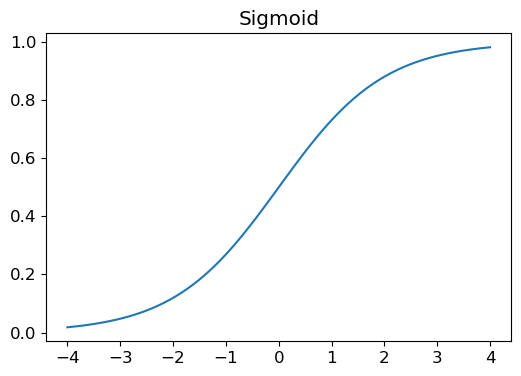

In [87]:
#in code sigmoid
def sigmoid(x): return 1/(1+torch.exp(-x))
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

So in this case they just want to use sigmoid to bind the predictions (inputs between 0 and 1
Now they define loss like this:

In [88]:

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Now we're going into the advantages of mini batches:
we can find the average loss for a few items instead of the whole dataset
Finding thhe correct batch size can be hard.
Larger means you get a more accurate and stable estimate of the gradients, but long time.
Mini batches are also important for parallelization.
We also shuffle each epoch before making batches
A DataLoader takes a python collection and turnsit into an iterator over mini-batches.

In [89]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)
     

[tensor([3, 6, 0, 1, 4]),
 tensor([ 8, 10,  5, 11,  2]),
 tensor([ 7, 12, 13,  9, 14])]

A collection that contains tuples of independent and dependent variables is known in pytorch as a dataset

In [90]:
#Here's a simple dataset:
ds = L(enumerate(string.ascii_lowercase))
ds
     

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j'),(10, 'k'),(11, 'l'),(12, 'm'),(13, 'n'),(14, 'o'),(15, 'p'),(16, 'q'),(17, 'r'),(18, 's'),(19, 't')...]

In [91]:
#pass it to loader and we'll get some minibatches:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 0, 10, 11, 17, 24, 25]), ('a', 'k', 'l', 'r', 'y', 'z')),
 (tensor([18, 19,  1,  2, 22,  3]), ('s', 't', 'b', 'c', 'w', 'd')),
 (tensor([ 5,  6,  4, 13,  9,  7]), ('f', 'g', 'e', 'n', 'j', 'h')),
 (tensor([23, 14, 15,  8, 12, 20]), ('x', 'o', 'p', 'i', 'm', 'u')),
 (tensor([21, 16]), ('v', 'q'))]

Gradient descent quickly summarized:
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr

In [92]:
#initialize params

weights = init_params((28*28,1))
bias = init_params(1)

In [93]:
#DataLoader from Dataset:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [94]:
#same with validation
valid_dl = DataLoader(valid_dset, batch_size=256)

In [95]:
#create size 4 mini batch
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [96]:

preds = linear1(batch)
preds

tensor([[-2.1876],
        [-8.3973],
        [ 2.5000],
        [-4.9473]], grad_fn=<AddBackward0>)

In [97]:
loss = mnist_loss(preds, train_y[:4])
loss
     

tensor(0.7419, grad_fn=<MeanBackward0>)

In [98]:
#get grads
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0061), tensor([-0.0420]))

In [99]:
#put it together
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [100]:
#test it:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad
     

(tensor(-0.0121), tensor([-0.0840]))

In [101]:
#loss.backward actually adds the gradients of loss to any that are stored
#so we need to zero the weights and biases each time
#note that in-place operations end in an underscore
weights.grad.zero_()
bias.grad.zero_();

In [105]:
#basic loop:

def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [106]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [ True],
        [False]])

In [107]:

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [108]:
#check it

batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

In [109]:
#put the batches back together:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [110]:

validate_epoch(linear1)

0.5264

In [111]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6664

In [112]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')
    

0.8265 0.89 0.9183 0.9275 0.9397 0.9466 0.9505 0.9524 0.9559 0.9578 0.9598 0.9608 0.9612 0.9617 0.9632 0.9637 0.9647 0.9656 0.9671 0.9676 

Pytorch gives us real functions to do all of this.
nn.Linear does the same thing as init_params and linear.


In [113]:
linear_model = nn.Linear(28*28,1)

In [114]:
#modules know what parameters are trainable
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [115]:
#Basic optimizer:

class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [116]:

opt = BasicOptim(linear_model.parameters(), lr)

In [117]:
#new loop:

def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()
     

In [118]:
#validation stays the same
validate_epoch(linear_model)

0.4607

In [119]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [120]:
train_model(linear_model, 20)

0.4932 0.7685 0.8554 0.9135 0.9345 0.9482 0.957 0.9633 0.9657 0.9677 0.9696 0.9716 0.9736 0.9745 0.976 0.977 0.9775 0.9775 0.978 0.9785 

Fastai also includes SGD class which does what our optmizer did:

In [121]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)
     

0.4932 0.8179 0.8496 0.914 0.9345 0.9482 0.957 0.9618 0.9657 0.9672 0.9692 0.9711 0.9741 0.975 0.976 0.9775 0.9775 0.978 0.9785 0.9789 

Learner.fit replaces train_model.
To create a Learner we first need Dataloader

In [122]:
dls = DataLoaders(dl, valid_dl)

To create a Learner without using an application (such as vision_learner) we need to pass in all the elements that we've created in this chapter: the DataLoaders, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [123]:

learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [124]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636709,0.503144,0.495584,00:00
1,0.429828,0.248517,0.777233,00:00
2,0.161680,0.155361,0.861629,00:00
3,0.072948,0.097722,0.917566,00:00
4,0.040128,0.073205,0.936212,00:00
5,0.027210,0.059466,0.950442,00:00
6,0.021837,0.050799,0.957802,00:00
7,0.019398,0.044980,0.964181,00:00
8,0.018122,0.040853,0.966143,00:00
9,0.017330,0.037788,0.968106,00:00


In [125]:
# basic network def:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [126]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)
     

They talk a bit for why ReLUs are good but they kind of separate the other functions by using the max.
Imagine stacking many relus (like maaany) to create many functions.

In [127]:
#pytorch way:

simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [128]:

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
     

In [129]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.333021,0.396112,0.512267,00:00
1,0.152461,0.235238,0.797350,00:00
2,0.083573,0.117471,0.911678,00:00
3,0.054309,0.078720,0.940628,00:00
4,0.040829,0.061228,0.956330,00:00
5,0.034006,0.051490,0.963690,00:00
6,0.030123,0.045381,0.966634,00:00
7,0.027619,0.041218,0.968106,00:00
8,0.025825,0.038200,0.969087,00:00
9,0.024441,0.035901,0.969578,00:00


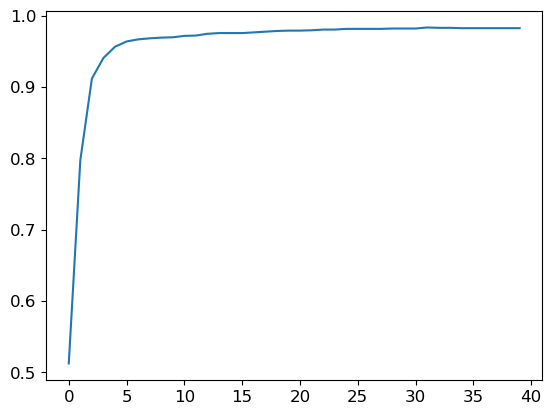

In [130]:
#plot accuracy over training:
plt.plot(L(learn.recorder.values).itemgot(2));

In [131]:
#final accuracy:
learn.recorder.values[-1][2]

0.98233562707901

Interestingly it mentions here to always add a nonlinearity (reLU) in between each pair of linear layers.
So why go deeper?
Deeper models need less parameters, smaller matrices.
We actually get better results this way.
Anyway lets throw this through our favorite 18 layer model resnet18:

In [132]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.114122,0.022083,0.996075,00:05
